### Import libraries

* `fiona` used to import/export geodata
* `shapely` allows usage of geometry objects 
* `matplotlib` visualization
* `sklearn`contains clustering algorithms
* `numpy` allows to handle data efficiently as vectors/matrices

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import fiona
from shapely.geometry.geo import shape
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
import numpy as np
from ipywidgets import interactive, interact
import ipywidgets as widgets

### Import data

In [2]:
data = []
with fiona.open('buildings.gpkg') as src:
    for f in src:
        pt = shape(f['geometry'])
        data.append((pt.x, pt.y))
X = np.array(data)
xlim = (min(X[:, 0]), max(X[:, 0]))
ylim = (min(X[:, 1]), max(X[:, 1]))
print(X)

[[620833.85998787 174007.15094989]
 [620868.99624114 174004.57972814]
 [621488.04172939 173610.55634672]
 ...
 [619923.282964   174145.152089  ]
 [619915.40984854 174142.34965183]
 [620032.66250959 174144.92612771]]


 ### Show data

(172955.3884779056, 174856.1735493605)

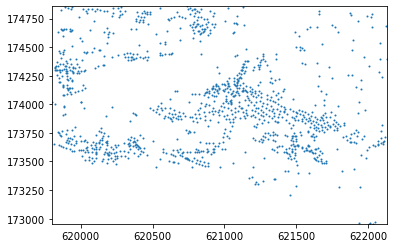

In [3]:
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.xlim(xlim)
plt.ylim(ylim)

### Finden von optimalen Werten von eps und min_samples

In [4]:
def plot_nb_dists(nearest_neighbor, metric='euclidean'):
    """ Plots distance sorted by `neared_neighbor`th

    Args:
        X (list of lists): list with data tuples
        nearest_neighbor (int): nr of nearest neighbor to plot
        metric (string): name of scipy metric function to use
    """
    
    tree = KDTree(X, leaf_size=2) 


    if not isinstance(nearest_neighbor, list):
        nearest_neighbor = [nearest_neighbor]

    max_nn = max(nearest_neighbor)

    dist, _ = tree.query(X, k=max_nn + 1)

    plt.figure()

    for nnb in nearest_neighbor:
        col = dist[:, nnb]
        col.sort()
        plt.plot(col, label="{}th nearest neighbor".format(nnb))
 
    #plt.ylim(0, min(250, max(dist[:, max_nn])))
    plt.ylabel("Distance to k nearest neighbor")
    plt.xlabel("Points sorted according to distance of k nearest neighbor")
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
interact(plot_nb_dists,
         nearest_neighbor=widgets.IntSlider(min=1, max=100, step=1, value=1, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='nearest_neighbor', min=1), Text…

### DBSCAN Clustering

In [9]:
def plot_dbscan(eps, min_samples, metric='euclidean'):
   
    db = DBSCAN(eps=eps,
                min_samples=min_samples,
                metric=metric).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    #print('Estimated number of clusters: %d' % n_clusters_)
    #print('Estimated number of noise points: %d' % n_noise_)
    
    # #############################################################################
    # Plot result
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure()
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
    
        class_member_mask = (labels == k)
    
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor=tuple(col), markersize=2)
    
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor=tuple(col), markersize=2)
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


In [10]:
interact(plot_dbscan,
         eps=widgets.IntSlider(min=1, max=300, step=1, value=50, continuous_update=False),
         min_samples=widgets.IntSlider(min=0, max=50, step=1, value=10, continuous_update=False));



interactive(children=(IntSlider(value=50, continuous_update=False, description='eps', max=300, min=1), IntSlid…